# NLP Document Locator

## Import statements

In [1]:
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

import pandas as pd
import numpy as np
import random
from datetime import datetime

[nltk_data] Downloading package punkt to C:\Users\Hitesh
[nltk_data]     Somani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Hitesh
[nltk_data]     Somani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
import json
with open(os.path.join(os.getcwd(), 'data', 'train2.json')) as file:
    data = json.load(file)

## Preprocessing

In [3]:
# words = []
# labels = []
# docs_x = []
# docs_y = []

# # ------------------- TOKENIZE ----------------- #
# for intent in data['intents']:
#     for pattern in intent['patterns']:
#         wrds = nltk.word_tokenize(pattern)
#         words.extend(wrds)
#         docs_x.append(wrds)
#         docs_y.append(intent["tag"])
        
#     if intent['tag'] not in labels:
#         labels.append(intent['tag'])
       

In [4]:
# # --------------------STOP WORD REMOVAL ----------#
# from nltk.corpus import stopwords
# stop_words = list(set(stopwords.words('english'))) 

# for word in words:
#     if word in stop_words:
#         words.remove(word)

# for wrd in docs_x:
#     for word in wrd:
#         if word in stop_words:
#             wrd.remove(word)

In [5]:
# # ------------------ REMOVE PUNCTUATION ----------- #
# import string
# for word in words:
#     word = word.translate(str.maketrans('', '', string.punctuation))
#     word = word.strip()


# for wrd in docs_x:
#     for word in wrd:
#         word = word.translate(str.maketrans('', '', string.punctuation))
#         word = word.strip()

In [6]:
# # ---------------- STEMMING ------------------ #
# words = [stemmer.stem(w.lower()) for w in words if w != "?"]
# words = sorted(list(set(words)))

# labels = sorted(labels)

In [7]:
rows = []
labels = []
for intent in data['intents']:
    rows.extend(intent['train_data'])
    label = []
    label.append(intent['label'])
    labels.extend(label*len(intent['train_data']))

### Date Recognition

In [8]:
from datetime import datetime

def decode_date(tokens):

    months_fullform = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'decemeber']
    months_shortform = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    month = 0
    for token in tokens:
        try:
            int(token)
        except:
            if token.lower() in months_fullform:
                month = months_fullform.index(token.lower()) + 1
            elif token.lower() in months_shortform:
                month = months_shortform.index(token.lower()) + 1
            tokens.remove(token)
        
    if len(tokens) > 2:
        if month:
            day = int(tokens[0])
            year = int(tokens[2])
        else:
            day = int(tokens[0])
            month = int(tokens[1])
            year = int(tokens[2])
    elif len(tokens) > 1:
        if month:
            day = int(tokens[0])
            year = 2020
        else:
            day = int(tokens[0])
            month = int(tokens[1])
            year = 2020
    elif len(tokens)==1:
        day = int(tokens[0])
        year = 2020
    return (day, month, year)

In [9]:
# !python3 -m spacy download en_core_web_lg
import spacy
sp_lg = spacy.load('en_core_web_lg')
import nltk
import re

query_date = {}
for idx, row in enumerate(rows):
    date_occurences = [(ent.text.strip(), ent.label_) for ent in sp_lg(row).ents if ent.label_ == 'DATE']
    query_date[row] = []
    
    for date in date_occurences:
        try:
            date_token = re.split('\s+|/|-|:',date[0])
            day, month, year = decode_date(date_token)
            query_date[row].append((f'{year}-{month}-{day}'))
            row = row.replace(date[0], "", 1)
            rows[idx] = row
        except:
            pass

### Universal Sentence Encoder

In [10]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [11]:
embedding = embed(rows)

X = pd.DataFrame(data=embedding.numpy())
X['label'] = labels

In [12]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.004851,-0.041964,-0.051808,0.019784,0.021853,0.021047,0.043125,-0.001204,0.022696,-0.077722,...,0.039908,0.052083,0.001058,0.065795,0.020701,-0.016375,-0.004406,-0.080554,-0.008480,marketing_google-home
1,0.010735,0.001598,-0.069327,0.045384,0.010653,0.049769,0.043490,0.014172,0.046780,-0.072827,...,-0.025100,0.028380,-0.019510,0.065093,0.041348,-0.048325,0.043596,-0.082165,0.022102,marketing_google-home
2,0.008150,-0.025516,-0.051825,0.018839,-0.011497,0.000663,0.038303,0.017663,0.018018,-0.060026,...,0.040483,0.025089,-0.002037,0.066990,0.038984,-0.020493,0.034859,-0.082567,-0.016747,marketing_google-home
3,-0.002875,0.017606,-0.065296,0.043215,-0.054827,0.022873,-0.023303,0.021275,0.003382,-0.069676,...,-0.022157,0.063531,0.023405,0.070117,0.007039,-0.045061,0.043073,-0.077875,0.045327,marketing_google-home
4,0.001530,-0.010831,-0.072277,0.053805,-0.000521,0.038126,0.050321,0.012032,0.036074,-0.065149,...,0.040641,0.056175,-0.001573,0.071447,0.020559,-0.032644,0.016579,-0.086796,0.013866,marketing_google-home


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1)
    fig, ax = plt.subplots(figsize=(18, 18))
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd", 
      ax=ax)
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
    message_embeddings_ = embed(messages_)
    plot_similarity(messages_, message_embeddings_, 90)


messages = rows

# run_and_plot(messages)
               

### t-SNE

In [14]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(X.drop(columns=['label']))
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 210 samples in 0.023s...
[t-SNE] Computed neighbors for 210 samples in 0.094s...
[t-SNE] Computed conditional probabilities for sample 210 / 210
[t-SNE] Mean sigma: 0.317312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.041050
[t-SNE] KL divergence after 300 iterations: 0.433612
t-SNE done! Time elapsed: 0.5489387512207031 seconds


In [15]:
tsne_results[0:9, 0]

array([-20.778887, -22.42348 , -20.544104, -19.543053, -22.060957,
       -20.619453, -22.049269, -20.498922, -19.5721  ], dtype=float32)

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

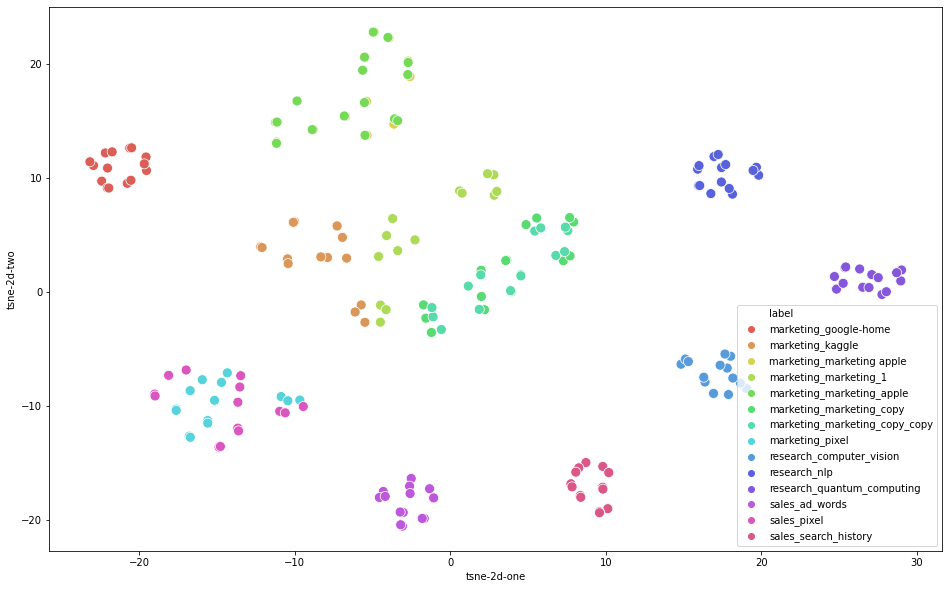

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# fig, ax = plt.subplots(figsize=(12,9))
# ax.scatter(tsne_results[0:18, 0], tsne_results[0:18, 1])
# plt.show()

df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['label'] = X['label']

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 14),
    data=df_subset,
    legend="full",
    alpha=1,
    s=100
)

## Modelling

In [18]:
# Data Prepraration
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

y = X['label']
X = X.drop(columns=['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [19]:
set(X_train.index).intersection(set(X_test.index))

set()

So an empty intersection set of both sets proves that there is no observation common in train and test data

In [20]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [21]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [22]:
# Building Neural network
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = Sequential()
model.add(Dense(64, input_shape=(512,)))
model.add(Dense(100))
model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(len(set(y_train))))
model.add(Activation('softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              101000    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_4 (Dense)              (None, 14)                1414      
_________________________________________________________________
activation (Activation)      (None, 14)                0         
Total params: 241,846
Trainable params: 241,846
Non-trainable params: 0
__________________________________________________

In [24]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [25]:
from tensorflow import keras
keras.utils.plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [26]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))

Epoch 1/10
6/6 [==============================] - 0s 71ms/step - loss: 2.4940 - sparse_categorical_accuracy: 0.2679 - val_loss: 2.1997 - val_sparse_categorical_accuracy: 0.4524
Epoch 2/10
6/6 [==============================] - 0s 9ms/step - loss: 1.8049 - sparse_categorical_accuracy: 0.6548 - val_loss: 1.4847 - val_sparse_categorical_accuracy: 0.6905
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 1.0421 - sparse_categorical_accuracy: 0.7381 - val_loss: 0.7915 - val_sparse_categorical_accuracy: 0.7619
Epoch 4/10
6/6 [==============================] - 0s 11ms/step - loss: 0.5971 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.4476 - val_sparse_categorical_accuracy: 0.8810
Epoch 5/10
6/6 [==============================] - 0s 8ms/step - loss: 0.3626 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.2296 - val_sparse_categorical_accuracy: 0.9286
Epoch 6/10
6/6 [==============================] - 0s 8ms/step - loss: 0.2900 - sparse_categorical_accuracy: 0.8690 - 

In [27]:
#%tensorboard --logdir logs/fit

In [28]:
# gcloud compute ssh python-nlp-document-finder --project nlp-document-finder --zone us-west1-b -- -L 2222:localhost:6007 

### Prediction 

In [29]:
y_proba = model.predict(X_test)

In [30]:
y_pred = y_proba.argmax(axis=1)

In [31]:
y_proba

array([[3.33089475e-03, 9.88176405e-01, 3.87622531e-05, 6.48884708e-03,
        5.84847257e-05, 1.20912055e-05, 7.16042725e-10, 2.22999438e-06,
        3.22597771e-04, 3.88115950e-05, 8.23997439e-08, 9.96908275e-05,
        1.46731236e-06, 1.42964313e-03],
       [3.68684250e-12, 2.43363329e-10, 1.36126499e-10, 1.04821256e-05,
        6.57941257e-10, 1.58549145e-01, 8.41440082e-01, 2.96596255e-07,
        1.12327037e-08, 4.34956817e-08, 3.95460713e-11, 2.62856295e-12,
        1.59934531e-11, 9.84929261e-13],
       [8.90828123e-12, 1.95054931e-10, 3.70000801e-11, 4.33017476e-06,
        1.31115396e-10, 4.84959409e-02, 9.51499164e-01, 5.90224204e-07,
        3.69480198e-08, 1.87229166e-08, 1.57916014e-10, 7.31216682e-13,
        2.49118504e-11, 1.40734830e-12],
       [2.48978927e-06, 5.56615703e-07, 3.50548735e-12, 1.08207887e-12,
        4.19984035e-13, 3.23306411e-14, 3.90282945e-12, 6.53995400e-11,
        8.48887837e-04, 5.20240656e-06, 9.99037504e-01, 1.95869942e-09,
        3.719

In [32]:
le.classes_

array(['marketing_google-home', 'marketing_kaggle',
       'marketing_marketing apple', 'marketing_marketing_1',
       'marketing_marketing_apple', 'marketing_marketing_copy',
       'marketing_marketing_copy_copy', 'marketing_pixel',
       'research_computer_vision', 'research_nlp',
       'research_quantum_computing', 'sales_ad_words', 'sales_pixel',
       'sales_search_history'], dtype=object)

In [33]:
rows[X_test.index[2]]

'display marketing copy copy marketing document'

In [34]:
from operator import itemgetter
final_results = pd.DataFrame(data = list(itemgetter(*list(X_test.index))(rows)), index=X_test.index, columns=['inputs'])  

In [35]:
final_results['predictions'] = le.inverse_transform(y_pred)
final_results['true'] = le.inverse_transform(y_test)
final_results['query_search'] = ""

In [36]:
final_results

,inputs,predictions,true,query_search
24,please open kaggle marketing report,marketing_kaggle,marketing_kaggle,
91,open marketing copy copy marketing report,marketing_marketing_copy_copy,marketing_marketing_copy_copy,
98,display marketing copy copy marketing document,marketing_marketing_copy_copy,marketing_marketing_copy_copy,
163,display quantum computing research file,research_quantum_computing,research_quantum_computing,
52,show me marketing marketing document,marketing_marketing_1,marketing_marketing_1,
72,show me marketing apple marketing file,marketing_marketing_apple,marketing_marketing_apple,
121,open computer vision research report,research_computer_vision,research_computer_vision,
117,show me pixel marketing file,marketing_pixel,marketing_pixel,
103,display marketing copy copy marketing file,marketing_marketing_copy_copy,marketing_marketing_copy_copy,
106,open pixel marketing report,marketing_pixel,marketing_pixel,


In [37]:
for index in final_results.index:
    for intent in data['intents']:
        if intent['label'] == final_results.loc[index, 'predictions']:
            final_results.loc[index, 'query_search'] = intent['responses']
            print(intent['responses'])

['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\kaggle.docx']
['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\marketing_copy_copy.docx']
['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\marketing_copy_copy.docx']
['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\research\\quantum_computing.pdf']
['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\marketing_1.docx']
['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\marketing_apple.docx']
['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\research\\computer_vision.pdf']
['C:\\Users\\Hitesh Somani\\Docume

In [40]:
final_results

,inputs,predictions,true,query_search
24,please open kaggle marketing report,marketing_kaggle,marketing_kaggle,[C:\Users\Hitesh Somani\Documents\hobby_projec...
91,open marketing copy copy marketing report,marketing_marketing_copy_copy,marketing_marketing_copy_copy,[C:\Users\Hitesh Somani\Documents\hobby_projec...
98,display marketing copy copy marketing document,marketing_marketing_copy_copy,marketing_marketing_copy_copy,[C:\Users\Hitesh Somani\Documents\hobby_projec...
163,display quantum computing research file,research_quantum_computing,research_quantum_computing,[C:\Users\Hitesh Somani\Documents\hobby_projec...
52,show me marketing marketing document,marketing_marketing_1,marketing_marketing_1,[C:\Users\Hitesh Somani\Documents\hobby_projec...
72,show me marketing apple marketing file,marketing_marketing_apple,marketing_marketing_apple,[C:\Users\Hitesh Somani\Documents\hobby_projec...
121,open computer vision research report,research_computer_vision,research_computer_vision,[C:\Users\Hitesh Somani\Documents\hobby_projec...
117,show me pixel marketing file,marketing_pixel,marketing_pixel,[C:\Users\Hitesh Somani\Documents\hobby_projec...
103,display marketing copy copy marketing file,marketing_marketing_copy_copy,marketing_marketing_copy_copy,[C:\Users\Hitesh Somani\Documents\hobby_projec...
106,open pixel marketing report,marketing_pixel,marketing_pixel,[C:\Users\Hitesh Somani\Documents\hobby_projec...


## User Input Test

In [41]:
le.classes_

array(['marketing_google-home', 'marketing_kaggle',
       'marketing_marketing apple', 'marketing_marketing_1',
       'marketing_marketing_apple', 'marketing_marketing_copy',
       'marketing_marketing_copy_copy', 'marketing_pixel',
       'research_computer_vision', 'research_nlp',
       'research_quantum_computing', 'sales_ad_words', 'sales_pixel',
       'sales_search_history'], dtype=object)

In [42]:
import joblib

joblib.dump(le, 'le.joblib')

['le.joblib']

#### Test1: Asking with document name and folder name

In [43]:
user_input = ["Hi open the sales google home document please"]

embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [44]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for intent in data['intents']:
    if intent['label'] == le.inverse_transform(y_pred):
        print(f"Query search: {intent['responses']}")

label predicted: ['marketing_google-home']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\google-home.docx']


In [45]:
(y_proba)

array([[9.1507983e-01, 9.9203689e-03, 1.1941350e-05, 1.3952540e-06,
        6.9343428e-06, 7.9608153e-10, 2.7948860e-11, 2.7517540e-06,
        5.8065332e-04, 1.1724525e-06, 6.8040703e-05, 3.7181308e-03,
        2.0058653e-03, 6.8602845e-02]], dtype=float32)

#### Result: The user made a mistake. google home document is in marketing folder

#### Test2: Asking with document name and folder name but _'can you get me'_ this is not used in training data so far 

In [46]:
user_input = ["Hi can you get me sales pixel document"]

embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [47]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for intent in data['intents']:
    if intent['label'] == le.inverse_transform(y_pred):
        print(f"Query search: {intent['responses']}")

label predicted: ['sales_pixel']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\sales\\pixel.xlsx']


In [48]:
y_proba

array([[1.0827328e-05, 1.9613932e-05, 4.5282423e-08, 6.1806404e-09,
        4.7304837e-08, 6.5127692e-10, 9.8753361e-09, 2.4645131e-03,
        1.3154176e-05, 7.9702722e-10, 2.1197361e-07, 3.7453035e-05,
        9.9707282e-01, 3.8128975e-04]], dtype=float32)

#### Result: The user asked for correct document from correct folder and model answer is correct.

#### Test3: Asking with document name but no folder name

In [49]:
user_input = ["Hi can you get me pixel document"]

embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [50]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for intent in data['intents']:
    if intent['label'] == le.inverse_transform(y_pred):
        print(f"Query search: {intent['responses']}")

label predicted: ['sales_pixel']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\sales\\pixel.xlsx']


#### Result: The user asked for correct document but did not specify and folder. Model gave just one correct result

In [51]:
# Lets y_proba

y_proba

array([[3.44714063e-04, 7.71545019e-05, 1.02195024e-07, 4.52147226e-08,
        6.94204445e-08, 1.23928157e-08, 1.44374440e-06, 9.51916873e-02,
        5.22558345e-04, 2.57312411e-08, 1.54179852e-05, 4.83454778e-06,
        9.03470576e-01, 3.71331495e-04]], dtype=float32)

So here is one room for improvement. The model should also give high probability to second element of the above list sonce that corresponds to 'marketing_pixel' <br>
May be we can add few more such statements in training data itself.

#### Test4: Asking document created on a date

In [52]:
user_input = ["Please open kaggle marketing document created on 15 July"]

In [53]:
query_date = {}
for idx, row in enumerate(user_input):
    date_occurences = [(ent.text.strip(), ent.label_) for ent in sp_lg(row).ents if ent.label_ == 'DATE']
    query_date[row] = []
    
    for date in date_occurences:
        try:
            date_token = re.split('\s+|/|-|:',date[0])
            day, month, year = decode_date(date_token)
            query_date[row].append((day, month, year))
            row = row.replace(date[0], "", 1)
            user_input[idx] = row
        except:
            pass

In [54]:
embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [55]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for intent in data['intents']:
    if intent['label'] == le.inverse_transform(y_pred):
        print(f"Query search: {intent['responses']}")

label predicted: ['marketing_kaggle']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\kaggle.docx']


In [56]:
# Lets y_proba

y_proba

array([[1.0701958e-02, 9.7616142e-01, 9.6004806e-05, 6.5424815e-03,
        1.1217111e-04, 3.1797277e-05, 1.0575756e-08, 4.8472452e-06,
        1.4182862e-03, 2.7363628e-04, 5.6755821e-06, 2.9773440e-04,
        4.3969571e-06, 4.3494315e-03]], dtype=float32)

In [57]:
query_date

{'Please open kaggle marketing document created on 15 July': [(15, 7, 2020)]}

#### Test5: Asking document created on a date

In [58]:
user_input = ["Please open computer vision document created on 1/6/2019", "Please open computer vision document created on 1-6-2019", 
              "Give me google home document from 14/07", "Give me google home document from 14-07", "Give me google home document made 14 Jan", 
              "Give me nlp document made on March 12", "Give me quantum computing document"]

In [59]:
query_date = {}
for idx, row in enumerate(user_input):
    date_occurences = [(ent.text.strip(), ent.label_) for ent in sp_lg(row).ents if ent.label_ == 'DATE']
    query_date[row] = []
    for date in date_occurences:
        try:
            date_token = re.split('\s+|/|-|:',date[0])
            day, month, year = decode_date(date_token)
            query_date[row].append((f'{year}-{month}-{day}'))
            datetime.strptime(f'{year}-{month}-{day}', '%Y-%m-%d %H:%M:%S.%f')
            row = row.replace(date[0], "", 1)
            user_input[idx] = row
        except:
            pass

In [60]:
embedding = embed(user_input)
X_user = pd.DataFrame(data=embedding.numpy())

In [61]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)

In [62]:
y_pred

array([ 8,  8,  0,  0,  0,  9, 10], dtype=int64)

In [63]:
y_proba = model.predict(X_user)
y_pred = y_proba.argmax(axis=1)
print(f"label predicted: {le.inverse_transform(y_pred)}")
for pred in y_pred:
    for intent in data['intents']:
        if intent['label'] == le.inverse_transform(pred.reshape(1,)):
            print(f"Query search: {intent['responses']}")

label predicted: ['research_computer_vision' 'research_computer_vision'
 'marketing_google-home' 'marketing_google-home' 'marketing_google-home'
 'research_nlp' 'research_quantum_computing']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\research\\computer_vision.pdf']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\research\\computer_vision.pdf']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\google-home.docx']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\google-home.docx']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_projects\\nlp_document_finder\\nlp_document_finder\\Google\\marketing\\google-home.docx']
Query search: ['C:\\Users\\Hitesh Somani\\Documents\\hobby_p

In [64]:
# Lets y_proba
y_proba

array([[3.69001962e-02, 1.23571068e-01, 1.60890451e-07, 2.24428368e-06,
        8.17681425e-08, 8.05807421e-09, 8.73096762e-10, 1.65811598e-05,
        7.97115743e-01, 3.64390035e-05, 1.53713208e-03, 1.70945041e-05,
        5.82337496e-04, 4.02210280e-02],
       [3.69001962e-02, 1.23571068e-01, 1.60890451e-07, 2.24428368e-06,
        8.17681425e-08, 8.05807421e-09, 8.73096762e-10, 1.65811598e-05,
        7.97115743e-01, 3.64390035e-05, 1.53713208e-03, 1.70945041e-05,
        5.82337496e-04, 4.02210280e-02],
       [9.99142170e-01, 3.04019952e-04, 2.62682107e-08, 2.85291044e-08,
        6.22057961e-09, 1.68365617e-11, 1.16264316e-11, 3.26178542e-06,
        4.16752911e-04, 1.64495475e-08, 2.20159491e-05, 3.19826654e-08,
        3.37482629e-06, 1.08495980e-04],
       [9.99142170e-01, 3.04019952e-04, 2.62682107e-08, 2.85291044e-08,
        6.22057961e-09, 1.68365617e-11, 1.16264316e-11, 3.26178542e-06,
        4.16752911e-04, 1.64495475e-08, 2.20159491e-05, 3.19826654e-08,
        3.374

In [65]:
query_date

{'Please open computer vision document created on 1/6/2019': [],
 'Please open computer vision document created on 1-6-2019': ['2019-6-1'],
 'Give me google home document from 14/07': [],
 'Give me google home document from 14-07': ['2020-7-14'],
 'Give me google home document made 14 Jan': ['2020-1-14'],
 'Give me nlp document made on March 12': ['2020-3-12'],
 'Give me quantum computing document': []}

### Save model

In [66]:
model.save('model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
